# How do delivery fees vary across platforms and locations?

In [38]:

import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Connect + attach
conn = sqlite3.connect(DELIVEROO_DB)
conn.execute(f"ATTACH DATABASE '{TAKEAWAY_DB}' AS ta;")
conn.execute(f"ATTACH DATABASE '{UBEREATS_DB}' AS ue;")

import matplotlib.pyplot as plt
import seaborn as sns  # optional; used only for nicer defaults

fees_by_postal_sql = """
WITH all_fees AS (
  -- Deliveroo
  SELECT
    'deliveroo' AS platform,
    CAST(postal_code AS TEXT) AS postal_code,
    CAST(delivery_fee AS REAL) AS delivery_fee
  FROM restaurants
  WHERE postal_code IS NOT NULL
    AND delivery_fee IS NOT NULL
    AND CAST(delivery_fee AS REAL) >= 0

  UNION ALL

  -- Takeaway: attach restaurant fee to each delivery location
  SELECT
    'takeaway' AS platform,
    CAST(l.postalCode AS TEXT) AS postal_code,
    CAST(r.deliveryFee AS REAL) AS delivery_fee
  FROM ta.locations l
  JOIN ta.locations_to_restaurants lr ON lr.location_id = l.ID
  JOIN ta.restaurants r ON r.primarySlug = lr.restaurant_id
  WHERE l.postalCode IS NOT NULL
    AND r.deliveryFee IS NOT NULL
    AND CAST(r.deliveryFee AS REAL) >= 0
)
SELECT
  postal_code,
  platform,
  COUNT(*) AS n_rows,
  ROUND(AVG(delivery_fee), 2) AS avg_fee,
  ROUND(MIN(delivery_fee), 2) AS min_fee,
  ROUND(MAX(delivery_fee), 2) AS max_fee
FROM all_fees
GROUP BY postal_code, platform
HAVING n_rows >= 10
ORDER BY avg_fee DESC;
"""

fees_by_postal = q(conn, fees_by_postal_sql)
fees_by_postal.head(20)


,postal_code,platform,n_rows,avg_fee,min_fee,max_fee
0,3061,takeaway,28,5.86,0.00,20.00
1,9688,takeaway,10,5.60,0.00,12.00
2,3717,takeaway,11,5.40,0.00,14.90
3,1761,takeaway,44,5.18,0.00,20.00
4,3790,takeaway,28,5.18,0.00,10.00
5,1750,takeaway,124,5.11,0.00,20.00
6,1030,deliveroo,54,4.99,4.99,4.99
7,1080,deliveroo,11,4.99,4.99,4.99
8,1082,deliveroo,15,4.99,4.99,4.99
9,1140,deliveroo,26,4.99,4.99,4.99


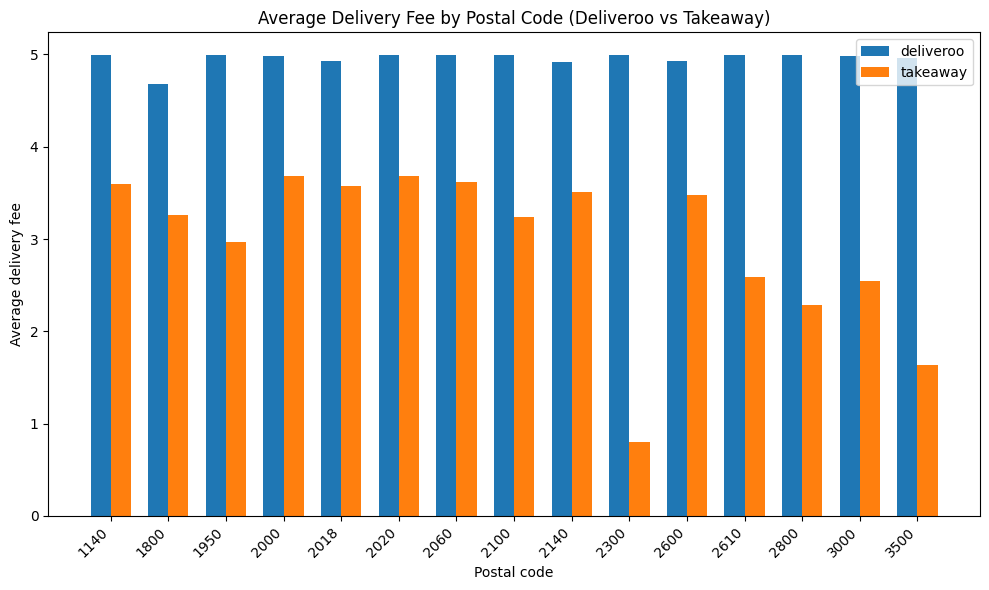

In [39]:
import matplotlib.pyplot as plt

# pivot to compare platforms side by side
p = (fees_by_postal
     .pivot_table(index="postal_code", columns="platform", values="avg_fee")
     .dropna(thresh=2)               # keep postal codes where both platforms exist
     .head(15)                       # keep it readable
     .reset_index())

plt.figure(figsize=(10, 6))
x = range(len(p))
width = 0.35

plt.bar([i - width/2 for i in x], p["deliveroo"], width=width, label="deliveroo")
plt.bar([i + width/2 for i in x], p["takeaway"],  width=width, label="takeaway")

plt.xticks(list(x), p["postal_code"], rotation=45, ha="right")
plt.title("Average Delivery Fee by Postal Code (Deliveroo vs Takeaway)")
plt.xlabel("Postal code")
plt.ylabel("Average delivery fee")
plt.legend()
plt.tight_layout()
plt.show()


# Deliveroo delivery cost

In [40]:

import pandas as pd
import re

# -------------------------------------------------------------------
# Extract rating signals per platform (name + postal code + rating + n_reviews)
# Notes:
# - Takeaway postal codes are derived via locations_to_restaurants -> locations.
# - UberEats review_count is stored as TEXT and may include a "+" suffix (e.g., "100+").
# -------------------------------------------------------------------

deliveroo_sql = """
SELECT
  'deliveroo' AS platform,
  TRIM(name) AS name,
  TRIM(CAST(postal_code AS TEXT)) AS postal_code,
  CAST(rating AS REAL) AS rating,
  CAST(rating_number AS INT) AS review_count
FROM restaurants
WHERE postal_code IS NOT NULL AND TRIM(postal_code) <> ''
  AND rating IS NOT NULL AND CAST(rating AS REAL) > 0;
"""

takeaway_sql = """
SELECT
  'takeaway' AS platform,
  TRIM(r.name) AS name,
  TRIM(CAST(l.postalCode AS TEXT)) AS postal_code,
  CAST(r.ratings AS REAL) AS rating,
  CAST(r.ratingsNumber AS INT) AS review_count
FROM ta.restaurants r
JOIN ta.locations_to_restaurants lr ON lr.restaurant_id = r.primarySlug
JOIN ta.locations l ON l.ID = lr.location_id
WHERE l.postalCode IS NOT NULL AND TRIM(CAST(l.postalCode AS TEXT)) <> ''
  AND r.ratings IS NOT NULL AND CAST(r.ratings AS REAL) > 0;
"""

ubereats_sql = """
SELECT
  'ubereats' AS platform,
  TRIM(COALESCE(sanitized_title, title)) AS name,
  TRIM(location__postal_code) AS postal_code,
  CAST(rating__rating_value AS REAL) AS rating,
  CASE
    WHEN rating__review_count LIKE '%+%' THEN CAST(REPLACE(rating__review_count,'+','') AS INT)
    ELSE CAST(rating__review_count AS INT)
  END AS review_count
FROM ue.restaurants
WHERE location__postal_code IS NOT NULL AND TRIM(location__postal_code) <> ''
  AND rating__rating_value IS NOT NULL AND CAST(rating__rating_value AS REAL) > 0;
"""

df_del = q(conn, deliveroo_sql)
df_ta  = q(conn, takeaway_sql)
df_ue  = q(conn, ubereats_sql)

# -------------------------------------------------------------------
# Normalize fields and build a deterministic match key: postal_code + normalized_name
# Normalization:
# - postal_code: digits only; enforce 4-digit Belgian postal codes
# - name_norm: lowercase alphanumerics only (removes whitespace/punctuation)
# -------------------------------------------------------------------

def norm_name(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())

def clean_postal(x) -> str:
    return re.sub(r"[^0-9]", "", str(x))

all_df = pd.concat([df_del, df_ta, df_ue], ignore_index=True)
all_df["postal_code"] = all_df["postal_code"].apply(clean_postal)
all_df = all_df[all_df["postal_code"].str.len() == 4].copy()

all_df["name_norm"] = all_df["name"].apply(norm_name)
all_df["match_key"] = all_df["postal_code"] + "|" + all_df["name_norm"]

# -------------------------------------------------------------------
# Deduplicate within each platform on the same match_key.
# Keep the observation with the highest review_count as the most reliable signal.
# -------------------------------------------------------------------

all_df = all_df.sort_values("review_count", ascending=False)
all_df = all_df.drop_duplicates(subset=["platform", "match_key"], keep="first")

# -------------------------------------------------------------------
# Pivot to one row per match_key with platform-specific ratings.
# Retain metadata (postal_code + representative name) for readability.
# Filter to matches present on at least two platforms.
# -------------------------------------------------------------------

ratings_wide = (all_df
                .pivot(index="match_key", columns="platform", values="rating")
                .reset_index())

meta = (all_df.groupby("match_key", as_index=False)
        .agg(postal_code=("postal_code", "first"),
             example_name=("name", "first")))

matched = ratings_wide.merge(meta, on="match_key", how="left")
matched["platform_count"] = matched[["deliveroo", "takeaway", "ubereats"]].notna().sum(axis=1)

matched_2plus = matched[matched["platform_count"] >= 2].copy()
matched_2plus.head(10)


C:\Users\welde\AppData\Local\Temp\ipykernel_41120\3958094578.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_df = pd.concat([df_del, df_ta, df_ue], ignore_index=True)


KeyError: "['ubereats'] not in index"

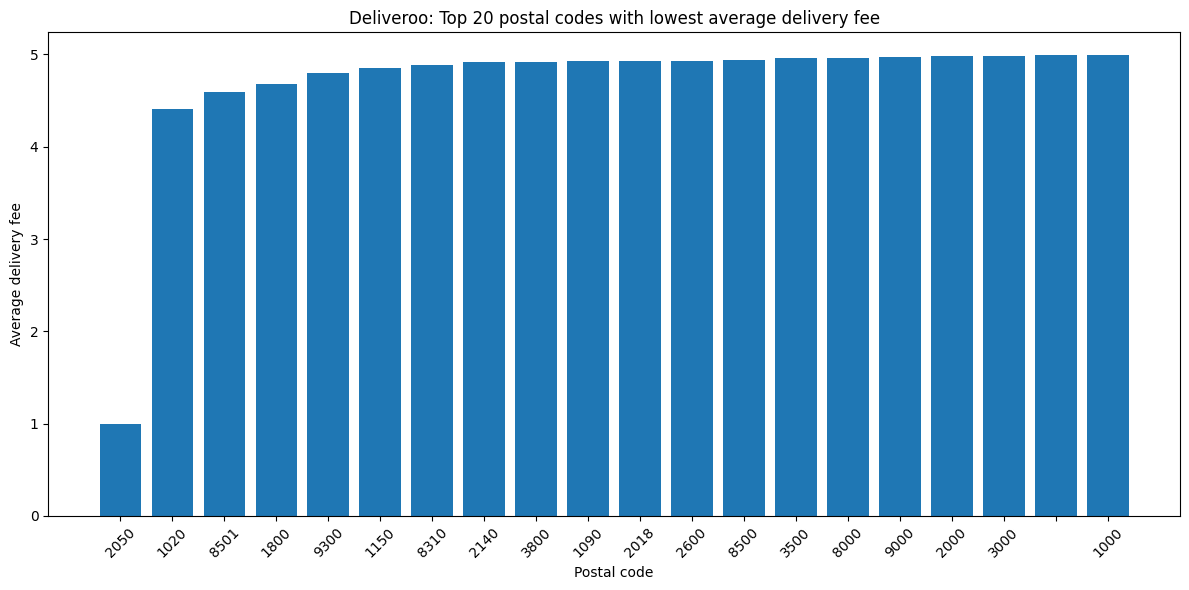

In [41]:
import matplotlib.pyplot as plt

top20 = df_deliveroo_fees.head(20)

plt.figure(figsize=(12, 6))
plt.bar(top20["postal_code"].astype(str), top20["delivery_fee"])
plt.title("Deliveroo: Top 20 postal codes with lowest average delivery fee")
plt.xlabel("Postal code")
plt.ylabel("Average delivery fee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Average ratings by category and platform

In [25]:
import pandas as pd

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Deliveroo (main)
query_deliveroo = """
SELECT 
    category AS Category,
    ROUND(AVG(rating), 2) AS "Average rating",
    'Deliveroo' AS Platform
FROM restaurants
WHERE category IN ('Italian', 'Burgers', 'Sushi', 'Turkish', 'Thai')
GROUP BY category;
"""

# Takeaway (ta)
query_takeaway = """
WITH mapped AS (
  SELECT
    CASE
      WHEN cr.category_id IN ('italian-pizza_271', 'pasta_1614') THEN 'Italian'
      WHEN cr.category_id = 'burgers_1984' THEN 'Burgers'
      WHEN cr.category_id IN ('thai_61', 'curry_731') THEN 'Thai'
      WHEN cr.category_id IN ('pita-kebab_651', 'shoarma_2014', 'turkish-pizza', 'turkish_511') THEN 'Turkish'
      WHEN cr.category_id IN ('sushi_51', 'japanene_551') THEN 'Sushi'
      ELSE NULL
    END AS Category,
    r.ratings AS rating
  FROM ta.categories_restaurants cr
  JOIN ta.restaurants r
    ON cr.restaurant_id = r.primarySlug
)
SELECT
  Category,
  ROUND(AVG(rating), 2) AS "Average rating",
  'Takeaway' AS Platform
FROM mapped
WHERE Category IN ('Italian', 'Burgers', 'Sushi', 'Turkish', 'Thai')
  AND rating IS NOT NULL
GROUP BY Category;
"""

# UberEats (ue)
query_ubereats = """
WITH mapped AS (
  SELECT
    CASE
      WHEN rtc.category IN ('Kebab', 'Turks', 'Turque') THEN 'Turkish'
      WHEN rtc.category IN ('Japans', 'Japonaise') THEN 'Sushi'
      WHEN rtc.category IN ('Pizza', 'Pizzas', 'Italiaans', 'Italienne', 'Pasta') THEN 'Italian'
      WHEN rtc.category IN ('Hamburgers', 'Amerikaans', 'AmÃ©ricain') THEN 'Burgers'
      WHEN rtc.category IN ('Thais') THEN 'Thai'
      ELSE NULL
    END AS Category,
    r.rating__rating_value AS rating
  FROM ue.restaurant_to_categories rtc
  JOIN ue.restaurants r
    ON r.id = rtc.restaurant_id
)
SELECT
  Category,
  ROUND(AVG(rating), 2) AS "Average rating",
  'Ubereats' AS Platform
FROM mapped
WHERE Category IN ('Italian', 'Burgers', 'Sushi', 'Turkish', 'Thai')
  AND rating IS NOT NULL
GROUP BY Category;
"""

df_deliveroo = q(conn, query_deliveroo)
df_takeaway  = q(conn, query_takeaway)
df_ubereats  = q(conn, query_ubereats)

df = pd.concat([df_deliveroo, df_takeaway, df_ubereats], ignore_index=True)
df["Average rating"] = pd.to_numeric(df["Average rating"], errors="coerce").round(2)

df_result = df.groupby(["Category", "Platform"], as_index=False)["Average rating"].mean()
df_result["Average rating"] = df_result["Average rating"].round(2)

df_result


,Category,Platform,Average rating
0,Burgers,Deliveroo,2.75
1,Burgers,Takeaway,3.64
2,Burgers,Ubereats,4.19
3,Italian,Deliveroo,2.90
4,Italian,Takeaway,3.78
5,Italian,Ubereats,4.26
6,Sushi,Deliveroo,2.70
7,Sushi,Takeaway,4.01
8,Sushi,Ubereats,4.40
9,Thai,Deliveroo,3.04


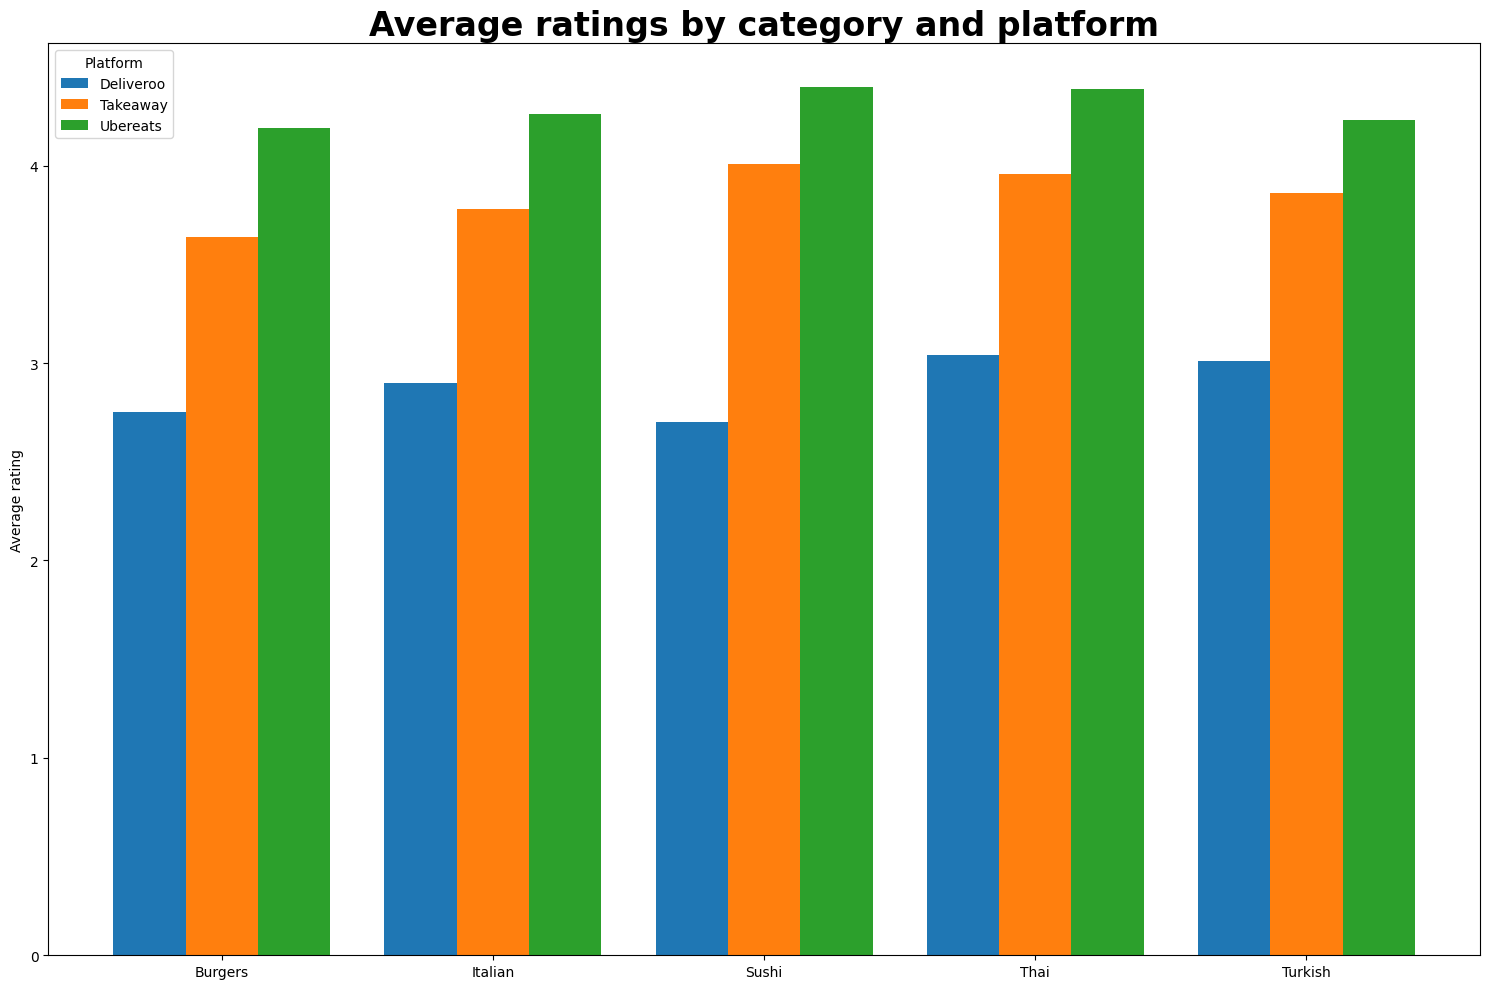

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Pivot to wide format: rows=Category, columns=Platform, values=Average rating
pivot = df_result.pivot(index="Category", columns="Platform", values="Average rating").fillna(0)

categories = pivot.index.tolist()
platforms = pivot.columns.tolist()

x = np.arange(len(categories))
width = 0.8 / max(len(platforms), 1)

plt.figure(figsize=(15, 10))

for i, p in enumerate(platforms):
    plt.bar(x + i*width - (len(platforms)-1)*width/2, pivot[p].values, width, label=p)

plt.xticks(x, categories, rotation=0)
plt.ylabel("Average rating")
plt.title("Average ratings by category and platform", fontsize=24, fontweight="bold")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()
